## Analysis Outline: Putative Cell Types × Behavioral Events

### Goal
Investigate whether **pyramidal neurons vs. interneurons** show different levels of significance across behavioral events.

### Dataset Structure
- **units_df**: grouped by `Recording` and `Unit number`  
  - `sig events`: list of events where the unit was significant  
  - `not sig events`: list of events where the unit was not significant  
  - `putative type`: classification of the unit (pyramidal or interneuron)  

- **sig_units**: subset of `units_df` containing only units with at least one `sig event`.

### Planned Analyses
1. **Overall proportions (baseline check)**  
   - % of pyramidal vs. interneuron units  
   - % of significant pyramidal vs. significant interneuron units  
   - % of sig units relative to all units  

2. **Event-level comparisons**  
   - For each event in:  
     `['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win']`  
     - Compute % of sig pyramidal units  
     - Compute % of sig interneuron units  
     - Compare distributions across events  

3. **Statistical testing (next steps)**  
   - Chi-square or Fisher’s Exact test to determine if **the proportion of significant units differs between events**.  
   - Possible logistic regression with predictors = event type, putative type.  

### Current Results (across all recordings)
- Interneurons / # sig units = **5.6%**  
- Interneurons / # units = **5.7%**  
- Pyramidal / # units = **94%**  
- Sig pyramidal / # sig units = **94%**  
- Sig pyramidal / # units = **23.1%**  
- Sig interneurons / # units = **1.3%**

---
✅ **Next Step**: Break down the percentages by event type to see if certain behaviors drive higher significance in pyramidal vs. interneurons.


In [73]:
import spike.spike_analysis.spike_collection as sc
import spike.spike_analysis.spike_recording as sr
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.normalization as norm
import spike.spike_analysis.single_cell as single_cell
import spike.spike_analysis.spike_collection as collection
import spike.spike_analysis.zscoring as zscoring
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import behavior.boris_extraction as boris
import matplotlib.pyplot as plt
import pickle
import re
import ast
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

In [74]:
pd.set_option('display.max_colwidth', 0)  # 0 means unlimited in newer pandas versions

# Show all rows
pd.set_option("display.max_rows", None)

# Show all columns
pd.set_option("display.max_columns", None)

# Don’t truncate column contents
pd.set_option("display.max_colwidth", None)

# Expand the display to the full width of the screen
pd.set_option("display.width", 0)


In [75]:
EVENTS = [
    'alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose',
    'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline',
    'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline',
    'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win'
]

### Dataframe of units, putative types, sig, events 

In [ ]:
df_path = r'C:\Users\thoma\Code\ResearchCode\diff_fam_social_memory_ephys\other_peoples_sutff\Thomas\reward_comp\outputs\final_sig_putative.csv'

### Preparing df for analysis

In [77]:
# 1) Read
units_df = pd.read_csv(df_path)

# 2) Convert stringified lists -> real lists
for col in ['sig events', 'not sig events']:
    units_df[col] = units_df[col].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str)
        else ([] if pd.isna(x) else x)
    )

# 3) Normalize labels
units_df['putative type'] = units_df['putative type'].astype(str).str.strip().str.lower()

# 4) (Re)build derived frames AFTER conversion
units = units_df.copy()
sig_units = units_df[units_df['sig events'].apply(lambda L: len(L) > 0)].copy()

# 5) Helpers (unchanged)
def event_tested(row, event):
    return (event in row['sig events']) or (event in row['not sig events'])

def event_significant(row, event):
    return event in row['sig events']


In [78]:
units_df.head()

,Recording,Unit number,sig events,not sig events,putative type
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,104,"[lose, low_comp_lose]","[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, low_comp, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,11,[],"[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, lose, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,122,[],"[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, lose, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,125,[],"[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, lose, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,126,[],"[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, lose, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal


##### Example usage of event_tested and event_significant

In [79]:
# Pick a single row (unit) and an event name
row = units_df.iloc[0]
print("Row sig events:", row['sig events'])
print("Row not sig events:", row['not sig events'])

# Example event
ev = "win"

print("Tested?", event_tested(row, ev))
print("Significant?", event_significant(row, ev))


Row sig events: ['lose', 'low_comp_lose']
Row not sig events: ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'low_comp', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win']
Tested? True
Significant? False


In [80]:
# number of high_comp_lose in sig_events in units_df
subset = units_df[units_df['sig events'].apply(lambda x: "high_comp_lose" in x)]
print(len(subset))
subset.head(20)

66


,Recording,Unit number,sig events,not sig events,putative type
28,20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec,52,"[alone_rewarded, high_comp, high_comp_lose, high_comp_win, low_comp, low_comp_win, win]","[alone_rewarded_baseline, high_comp_lose_baseline, high_comp_win_baseline, lose, low_comp_lose, low_comp_lose_baseline, low_comp_win_baseline, overall_pretone]",pyramidal
31,20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec,68,"[alone_rewarded, high_comp, high_comp_lose, high_comp_win, lose, low_comp, low_comp_win, win]","[alone_rewarded_baseline, high_comp_lose_baseline, high_comp_win_baseline, low_comp_lose, low_comp_lose_baseline, low_comp_win_baseline, overall_pretone]",pyramidal
33,20230612_112630_standard_comp_to_training_D1_subj_1-1_t1b3L_box2_merged.rec,34,"[high_comp, high_comp_lose, lose]","[alone_rewarded, alone_rewarded_baseline, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
42,20230612_112630_standard_comp_to_training_D1_subj_1-1_t1b3L_box2_merged.rec,83,"[high_comp, high_comp_lose, lose, low_comp, low_comp_lose]","[alone_rewarded, alone_rewarded_baseline, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
47,20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec,1,"[high_comp_lose, lose]","[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
49,20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec,14,"[high_comp_lose, lose, low_comp_lose]","[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, low_comp, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
52,20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec,2,[high_comp_lose],"[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, lose, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
54,20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec,211,[high_comp_lose],"[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, lose, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",interneuron
56,20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec,240,"[high_comp_lose, lose]","[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, low_comp, low_comp_lose, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal
58,20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec,283,"[high_comp_lose, lose, low_comp, low_comp_lose]","[alone_rewarded, alone_rewarded_baseline, high_comp, high_comp_lose_baseline, high_comp_win, high_comp_win_baseline, low_comp_lose_baseline, low_comp_win, low_comp_win_baseline, overall_pretone, win]",pyramidal


## Fishers Exact Test: Event-Level Significance by Putative Cell Type

### Purpose
Quantify and compare, **for each behavioral event**, the proportion of units that are significant among those **actually tested** for that event, split by **pyramidal** vs **interneuron**, and assess whether the proportions differ (Fisher’s exact test with FDR correction across events).

---

### Key Definitions
- **Tested (unit, event)**: An event is considered *tested* for a unit if it appears in **either** that unit’s `sig events` **or** `not sig events`.  
  - `sig events`: events where the unit was significant  
  - `not sig events`: events where the unit was evaluated but not significant  
  - If an event is in neither list, the unit was **not** tested for that event and is excluded from the denominator.

---

### Per-Event Summary Procedure (`summarize_event`)
1. **Filter to tested units**  
   For a given `event`, keep only rows (units) where `event ∈ (sig events ∪ not sig events)`.  
   This ensures the denominator contains only units that were actually evaluated for that event.

2. **Split by putative type**  
   From the *tested* subset, create:
   - `pyr`: tested pyramidal units  
   - `itn`: tested interneuron units

3. **Count tested vs significant**  
   For each type, compute:
   - `n_tested_*` = number of tested units  
   - `n_sig_*` = number of those that have the event in `sig events`  
   - `pct_sig_*` = `n_sig_* / n_tested_* × 100`

4. **Build 2×2 contingency table**  
   For the event, construct:


In [81]:
def summarize_event(units_df, event):
    """
    Build per-event 2x2 counts for [sig vs not-sig] x [pyramidal vs interneuron],
    compute percentages and Fisher's exact test.
    """
    # Filter units that were actually tested for this event
    tested = units_df[units_df.apply(lambda r: event_tested(r, event), axis=1)].copy()
    if tested.empty:
        print("tested empty")
        return {
            'event': event,
            'n_tested_pyramidal': 0, 'n_sig_pyramidal': 0, 'pct_sig_pyramidal': np.nan,
            'n_tested_interneuron': 0, 'n_sig_interneuron': 0, 'pct_sig_interneuron': np.nan,
            'odds_ratio_Pyr_vs_Int': np.nan, 'p_value': np.nan
        }

    # Split by putative type
    pyr = tested[tested['putative type'].str.contains('pyramidal', case=False, na=False)]
    itn = tested[tested['putative type'].str.contains('interneuron', case=False, na=False)]

    def counts(df):
        n_tested = len(df)
        n_sig = df.apply(lambda r: event_significant(r, event), axis=1).sum()
        return n_tested, int(n_sig), int(n_tested - n_sig)

    n_tested_pyr, n_sig_pyr, n_nsig_pyr = counts(pyr)
    n_tested_int, n_sig_int, n_nsig_int = counts(itn)

    # Build 2x2 table for Fisher: rows=type, cols=outcome
    # [[sig_pyr, notsig_pyr],
    #  [sig_int, notsig_int]]
    table = np.array([[n_sig_pyr, n_nsig_pyr],
                      [n_sig_int, n_nsig_int]], dtype=int)

    # Guard for degenerate tables (all zeros)
    if table.sum() == 0 or (n_tested_pyr == 0 and n_tested_int == 0):
        or_val, p_val = np.nan, np.nan
    else:
        # Use Fisher's exact (safe with small counts)
        or_val, p_val = fisher_exact(table, alternative='two-sided')

    out = {
        'event': event,
        'n_tested_pyramidal': n_tested_pyr,
        'n_sig_pyramidal': n_sig_pyr,
        'pct_sig_pyramidal': (n_sig_pyr / n_tested_pyr * 100.0) if n_tested_pyr > 0 else np.nan,
        'n_tested_interneuron': n_tested_int,
        'n_sig_interneuron': n_sig_int,
        'pct_sig_interneuron': (n_sig_int / n_tested_int * 100.0) if n_tested_int > 0 else np.nan,
        'odds_ratio_Pyr_vs_Int': or_val,
        'p_value': p_val,
    }
    return out

# Run for all events
summary_rows = [summarize_event(units, ev) for ev in EVENTS]
event_summary = pd.DataFrame(summary_rows)

# Diagnostic: see which events actually had any tested units
event_summary['n_tested_total'] = (
    event_summary['n_tested_pyramidal'].fillna(0).astype(int) +
    event_summary['n_tested_interneuron'].fillna(0).astype(int)
)

# FDR only if we have at least one finite p-value
mask = event_summary['p_value'].notna()

if mask.sum() > 0:
    rej, p_fdr, _, _ = multipletests(event_summary.loc[mask, 'p_value'], method='fdr_bh')
    event_summary.loc[mask, 'p_fdr'] = p_fdr
    event_summary.loc[mask, 'reject_FDR_0.05'] = rej
else:
    # No valid p-values: fill sensible defaults
    event_summary['p_fdr'] = np.nan
    event_summary['reject_FDR_0.05'] = False

# Optional: filter out events with no tests (helps readability)
event_summary = event_summary[event_summary['n_tested_total'] > 0].reset_index(drop=True)

event_summary.head(15)


,event,n_tested_pyramidal,n_sig_pyramidal,pct_sig_pyramidal,n_tested_interneuron,n_sig_interneuron,pct_sig_interneuron,odds_ratio_Pyr_vs_Int,p_value,n_tested_total,p_fdr,reject_FDR_0.05
0,alone_rewarded,338,18,5.325444,19,2,10.526316,0.478125,0.288532,357,1.0,False
1,alone_rewarded_baseline,209,4,1.913876,15,0,0.000000,inf,1.000000,224,1.0,False
2,high_comp,612,28,4.575163,37,2,5.405405,0.839041,0.686175,649,1.0,False
3,high_comp_lose,568,62,10.915493,37,4,10.810811,1.010870,1.000000,605,1.0,False
4,high_comp_lose_baseline,227,4,1.762115,17,0,0.000000,inf,1.000000,244,1.0,False
5,high_comp_win,512,29,5.664062,27,2,7.407407,0.750518,0.663304,539,1.0,False
6,high_comp_win_baseline,209,4,1.913876,15,0,0.000000,inf,1.000000,224,1.0,False
7,lose,583,56,9.605489,37,3,8.108108,1.204301,1.000000,620,1.0,False
8,low_comp,612,39,6.372549,37,2,5.405405,1.191099,1.000000,649,1.0,False
9,low_comp_lose,470,41,8.723404,30,3,10.000000,0.860140,0.739775,500,1.0,False


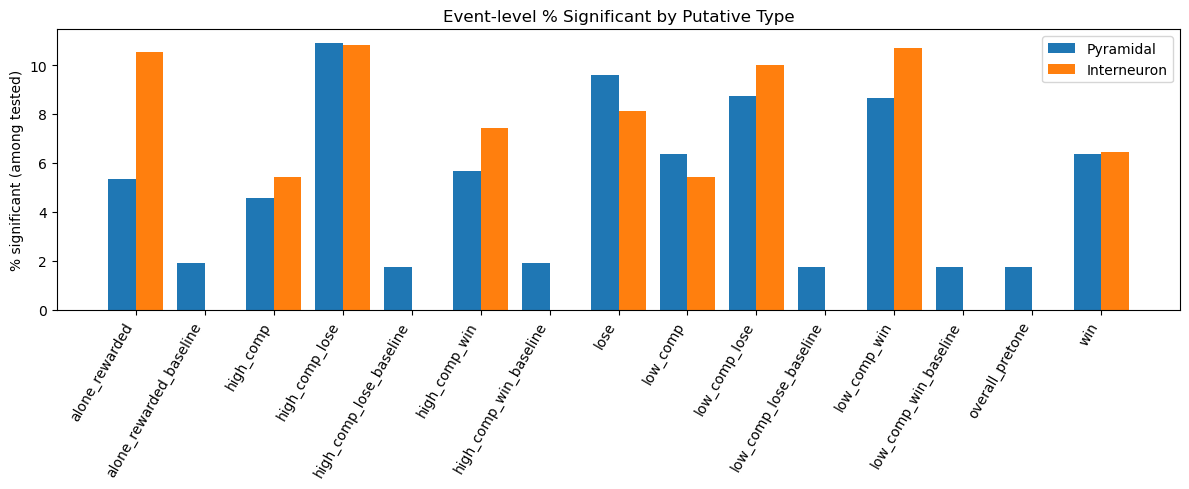

In [82]:
plot_df = event_summary.copy()
x = np.arange(len(plot_df['event']))

plt.figure(figsize=(12,5))
plt.bar(x - 0.2, plot_df['pct_sig_pyramidal'], width=0.4, label='Pyramidal')
plt.bar(x + 0.2, plot_df['pct_sig_interneuron'], width=0.4, label='Interneuron')
plt.xticks(x, plot_df['event'], rotation=60, ha='right')
plt.ylabel('% significant (among tested)')
plt.title('Event-level % Significant by Putative Type')
plt.legend()
plt.tight_layout()
plt.show()


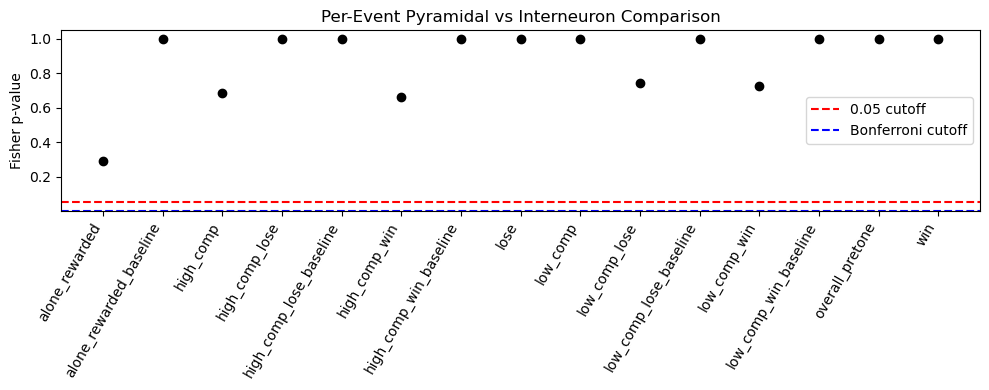

In [83]:
plt.figure(figsize=(10,4))
plt.scatter(plot_df['event'], plot_df['p_value'], color='black')
plt.axhline(0.05, color='red', linestyle='--', label='0.05 cutoff')
plt.axhline(0.05/len(plot_df), color='blue', linestyle='--', label='Bonferroni cutoff')
plt.xticks(rotation=60, ha='right')
plt.ylabel('Fisher p-value')
plt.title('Per-Event Pyramidal vs Interneuron Comparison')
plt.legend()
plt.tight_layout()
plt.show()


### Next: 
1. Test if there's a difference in increase and decrease between events
2.  check other events, check baseline is what we think it is
3. hand calculate pvalues make sure it's correct

In [84]:
# Build long-form table: one row per (unit, event) that was tested
rows = []
for _, r in units.iterrows():
    pt = r['putative type']
    rec = r['Recording']
    unit = r['Unit number']
    sig_set = set(r['sig events'] or [])
    nsig_set = set(r['not sig events'] or [])
    tested_events = sig_set | nsig_set
    for ev in tested_events:
        rows.append({
            'Recording': rec,
            'Unit': unit,
            'putative_type': pt,
            'event': ev,
            'sig': int(ev in sig_set)
        })

long_df = pd.DataFrame(rows)

# statsmodels logistic regression with cluster-robust SE by Recording (or by Unit)
import statsmodels.formula.api as smf

# Baseline model: main effects only
m1 = smf.glm('sig ~ C(event) + C(putative_type)',
             data=long_df, family=__import__('statsmodels.api').api.families.Binomial()).fit(cov_type='cluster', cov_kwds={'groups': long_df['Recording']})
print(m1.summary())

# Interaction model: allow type effect to vary by event
m2 = smf.glm('sig ~ C(event) * C(putative_type)',
             data=long_df, family=__import__('statsmodels.api').api.families.Binomial()).fit(cov_type='cluster', cov_kwds={'groups': long_df['Recording']})
print(m2.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    sig   No. Observations:                 6691
Model:                            GLM   Df Residuals:                     6674
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1491.1
Date:                Fri, 05 Sep 2025   Deviance:                       2982.2
Time:                        11:44:41   Pearson chi2:                 6.69e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01672
Covariance Type:              cluster                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

### Confidence Intervals: Wilson's and Jeffreys

#### Wilsons CI calculation

In [85]:
import math
from scipy.stats import norm

def wilson_ci(successes, n, alpha=0.05):
    """
    Wilson score confidence interval for a binomial proportion.
    
    Parameters
    ----------
    successes : int
        Number of successes (e.g., significant neurons).
    n : int
        Number of trials (e.g., tested neurons).
    alpha : float
        Significance level, default 0.05 → 95% CI.

    Returns
    -------
    (lower, upper) : tuple of floats
        Wilson score interval bounds (0–1).
    """
    if n == 0:
        return (math.nan, math.nan)

    if n == 0 or pd.isna(n) or pd.isna(successes):
        return (math.nan, math.nan)
    p = successes / n
    z = norm.ppf(1 - alpha/2)
    denom = 1 + z*z/n
    center = p + z*z/(2*n)
    half = z * math.sqrt(p*(1-p)/n + (z*z)/(4*n*n))
    lo = (center - half) / denom
    hi = (center + half) / denom
    return max(0.0, lo), min(1.0, hi)


#### Keeping columns we need

In [86]:

wide = event_summary[[
    "event",
    "n_tested_pyramidal", "n_sig_pyramidal", "pct_sig_pyramidal",
    "n_tested_interneuron", "n_sig_interneuron", "pct_sig_interneuron",
]]
wide.head()


,event,n_tested_pyramidal,n_sig_pyramidal,pct_sig_pyramidal,n_tested_interneuron,n_sig_interneuron,pct_sig_interneuron
0,alone_rewarded,338,18,5.325444,19,2,10.526316
1,alone_rewarded_baseline,209,4,1.913876,15,0,0.000000
2,high_comp,612,28,4.575163,37,2,5.405405
3,high_comp_lose,568,62,10.915493,37,4,10.810811
4,high_comp_lose_baseline,227,4,1.762115,17,0,0.000000


In [87]:
# Make a MultiIndex on columns: (metric, cell_type), then stack to long
tmp = wide.set_index("event")
tmp.columns = pd.MultiIndex.from_tuples(
    [c.rsplit("_", 1) for c in tmp.columns], names=["metric", "cell_type"]
)
long = (
    tmp.stack("cell_type")
       .reset_index()
       .rename(columns={"level_1": "cell_type"})
)

# Clean column names and compute proportion/percent from counts (more robust)
long = long.rename(columns={
    "n_tested": "n_tested",
    "n_sig": "n_sig",
    "pct_sig": "pct_sig"  # this is your original percent; we'll also recompute
})
long["prop"] = long["n_sig"] / long["n_tested"].replace(0, pd.NA)
long["pct"]  = long["prop"] * 100.0

# (Optional) add Wilson 95% CI
ci = long.apply(lambda r: wilson_ci(r["n_sig"], r["n_tested"]) if pd.notna(r["n_tested"]) else (math.nan, math.nan), axis=1)
long["ci_lo_prop"] = [a for a, _ in ci]
long["ci_hi_prop"] = [b for _, b in ci]
long["ci_lo_pct"]  = long["ci_lo_prop"] * 100.0
long["ci_hi_pct"]  = long["ci_hi_prop"] * 100.0

# Order rows: interneuron first, then pyramidal within each event
long["cell_type"] = pd.Categorical(long["cell_type"], ["interneuron", "pyramidal"])
long = long.sort_values(["event", "cell_type"]).reset_index(drop=True)

# The tidy table you want
tidy_event_by_type = long[[
    "event", "cell_type",
    "n_tested", "n_sig",
    "prop", "pct",          # recomputed from counts
    "pct_sig",              # your original percent column (keep if you want)
    "ci_lo_prop", "ci_hi_prop", "ci_lo_pct", "ci_hi_pct"  # optional CIs
]]

# Example: save to CSV for plotting
# tidy_event_by_type.to_csv("event_by_type_with_wilson.csv", index=False)

C:\Users\thoma\AppData\Local\Temp\ipykernel_9676\3748650863.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tmp.stack("cell_type")


In [88]:
tidy_event_by_type.head(15)

metric,event,cell_type,n_tested,n_sig,prop,pct,pct_sig,ci_lo_prop,ci_hi_prop,ci_lo_pct,ci_hi_pct
0,alone_rewarded,interneuron,19,2,0.105263,10.526316,10.526316,0.029359,0.313941,2.935856,31.394083
1,alone_rewarded,pyramidal,338,18,0.053254,5.325444,5.325444,0.033948,0.082601,3.394818,8.260135
2,alone_rewarded_baseline,interneuron,15,0,0.000000,0.000000,0.000000,0.000000,0.203883,0.000000,20.388330
3,alone_rewarded_baseline,pyramidal,209,4,0.019139,1.913876,1.913876,0.007467,0.048168,0.746724,4.816788
4,high_comp,interneuron,37,2,0.054054,5.405405,5.405405,0.014951,0.177047,1.495098,17.704654
5,high_comp,pyramidal,612,28,0.045752,4.575163,4.575163,0.031841,0.065329,3.184121,6.532903
6,high_comp_lose,interneuron,37,4,0.108108,10.810811,10.810811,0.042852,0.247085,4.285190,24.708532
7,high_comp_lose,pyramidal,568,62,0.109155,10.915493,10.915493,0.086088,0.137473,8.608764,13.747338
8,high_comp_lose_baseline,interneuron,17,0,0.000000,0.000000,0.000000,0.000000,0.184318,0.000000,18.431814
9,high_comp_lose_baseline,pyramidal,227,4,0.017621,1.762115,1.762115,0.006873,0.044424,0.687332,4.442362


C:\Users\thoma\AppData\Local\Temp\ipykernel_9676\3114886923.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = ~df["event"].str.contains(r"(baseline|pretone)", case=False, na=False)


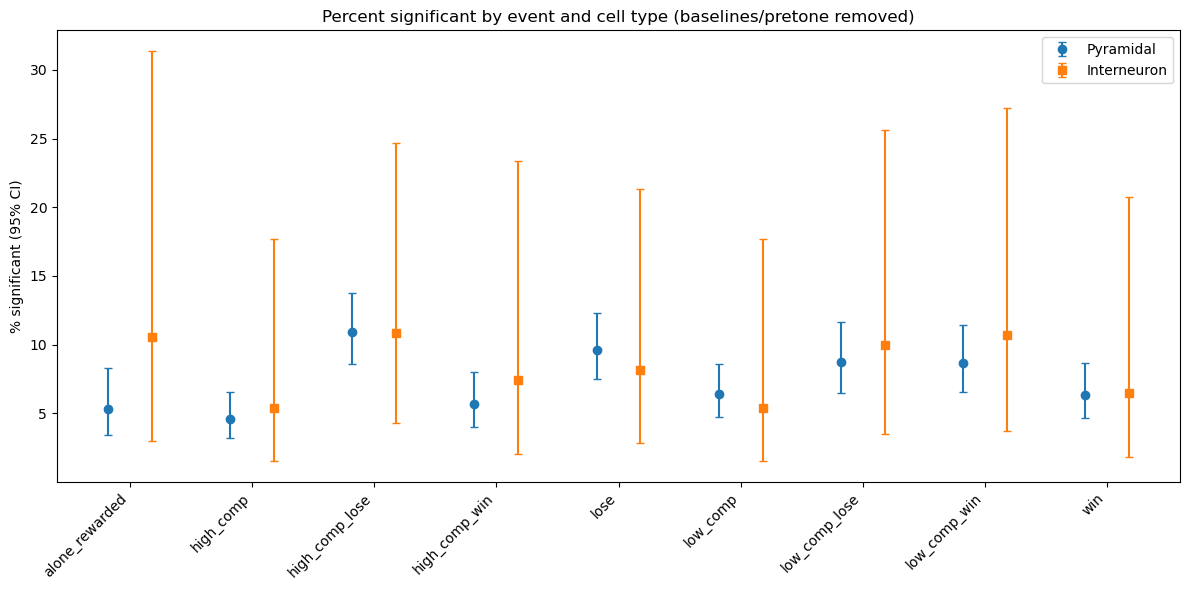

In [89]:
# columns: event, cell_type, n_tested, n_sig, prop, pct, pct_sig, ci_lo_prop, ci_hi_prop, ci_lo_pct, ci_hi_pct

df = tidy_event_by_type.copy()

# Drop non-interesting events (baselines / pretone)
mask = ~df["event"].str.contains(r"(baseline|pretone)", case=False, na=False)
df = df[mask].copy()

# Ensure consistent event order if you have a preferred list
preferred = [
    'alone_rewarded', 'high_comp', 'high_comp_lose', 'high_comp_win',
    'lose', 'low_comp', 'low_comp_lose', 'low_comp_win', 'win'
]
order = [e for e in preferred if e in df["event"].unique().tolist()]
if not order:  # fallback to alphabetical if none match
    order = sorted(df["event"].unique().tolist())

# Keep only events in 'order' and sort
df = df[df["event"].isin(order)]
df["event"] = pd.Categorical(df["event"], order)
df["cell_type"] = pd.Categorical(df["cell_type"], ["pyramidal", "interneuron"])
df = df.sort_values(["event", "cell_type"])

# Build x positions: two per event (pyramidal left, interneuron right)
events_unique = list(df["event"].cat.categories)
x_base = np.arange(len(events_unique))
offset = 0.18

# Split for convenience
pyr = df[df["cell_type"] == "pyramidal"]
itn = df[df["cell_type"] == "interneuron"]

# Align by event index
pyr = pyr.set_index("event").loc[events_unique]
itn = itn.set_index("event").loc[events_unique]

# y values and asymmetric error bars (%)
pyr_y = pyr["pct"].values
pyr_lo = (pyr["pct"] - pyr["ci_lo_pct"]).values
pyr_hi = (pyr["ci_hi_pct"] - pyr["pct"]).values
pyr_yerr = np.vstack([pyr_lo, pyr_hi])

itn_y = itn["pct"].values
itn_lo = (itn["pct"] - itn["ci_lo_pct"]).values
itn_hi = (itn["ci_hi_pct"] - itn["pct"]).values
itn_yerr = np.vstack([itn_lo, itn_hi])

plt.figure(figsize=(12,6))
plt.errorbar(x_base - offset, pyr_y, yerr=pyr_yerr, fmt='o', capsize=3, label='Pyramidal')
plt.errorbar(x_base + offset, itn_y, yerr=itn_yerr, fmt='s', capsize=3, label='Interneuron')

plt.xticks(x_base, events_unique, rotation=45, ha='right')
plt.ylabel('% significant (95% CI)')
plt.title('Percent significant by event and cell type (baselines/pretone removed)')
plt.legend()
plt.tight_layout()
plt.show()


- **Circles (`o`)** = **Pyramidal cells**  
  The percentage of pyramidal neurons that were significant for a given event.  

- **Squares (`s`)** = **Interneurons**  
  The percentage of interneurons that were significant for a given event.  

- **Vertical lines (error bars)** = **95% Wilson confidence intervals**  
  These show the uncertainty around the estimated percentage.  
  - **Short/narrow bars** mean the estimate is precise (due to there being more tested neurons.
  - **Long/wide bars** mean the estimate is uncertain (not many neurons tested).  


In [90]:
def _bisect_root(f, lo, hi, *, tol=1e-12, max_iter=10_000):
    """Simple robust bisection for a continuous f with opposite signs at ends."""
    f_lo, f_hi = f(lo), f(hi)
    if math.isnan(f_lo) or math.isnan(f_hi):
        raise ValueError("Function returned NaN at bracket endpoints.")
    if f_lo == 0: return lo
    if f_hi == 0: return hi
    if f_lo * f_hi > 0:
        # No sign change—fallback: return the endpoint with smaller |f|
        return lo if abs(f_lo) < abs(f_hi) else hi
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        f_mid = f(mid)
        if f_mid == 0 or (hi - lo) < tol:
            return mid
        if f_lo * f_mid <= 0:
            hi, f_hi = mid, f_mid
        else:
            lo, f_lo = mid, f_mid
    return 0.5 * (lo + hi)

def wilson_cc_interval(x, n, alpha=0.05):
    """
    Wilson score interval with continuity correction (Newcombe, 1998).
    Inverts the score test with ±0.5 continuity correction using bisection.

    Parameters
    ----------
    x : int
        Number of successes.
    n : int
        Number of trials.
    alpha : float
        Significance level (0.05 => 95% CI).

    Returns
    -------
    (lo, hi) : tuple of floats in [0, 1]
    """
    if n <= 0:
        return (math.nan, math.nan)
    if x < 0 or x > n:
        return (math.nan, math.nan)

    z = norm.ppf(1 - alpha / 2)

    # Edge cases: use one-sided roots only where needed
    if x == 0:
        # Lower bound is 0; solve upper with x + 0.5
        def f_hi(p):
            # (x + 0.5) - n p = z * sqrt(n p (1-p))
            if p <= 0 or p >= 1:
                return float('inf')  # push out of bracket
            return (x + 0.5) - n * p - z * math.sqrt(n * p * (1 - p))
        lo, hi = 0.0, _bisect_root(f_hi, 1e-15, 1 - 1e-15)
        return (0.0, min(1.0, max(0.0, hi)))

    if x == n:
        # Upper bound is 1; solve lower with x - 0.5
        def f_lo(p):
            # n p - (x - 0.5) = z * sqrt(n p (1-p))
            if p <= 0 or p >= 1:
                return -float('inf')  # push out of bracket
            return n * p - (x - 0.5) - z * math.sqrt(n * p * (1 - p))
        lo = _bisect_root(f_lo, 1e-15, 1 - 1e-15)
        return (min(1.0, max(0.0, lo)), 1.0)

    # General case: solve both bounds
    def f_lo(p):
        # n p - (x - 0.5) = z * sqrt(n p (1-p))
        if p <= 0 or p >= 1:
            return (n * p - (x - 0.5)) - z * 0.0  # sign consistent
        return n * p - (x - 0.5) - z * math.sqrt(n * p * (1 - p))

    def f_hi(p):
        # (x + 0.5) - n p = z * sqrt(n p (1-p))
        if p <= 0 or p >= 1:
            return (x + 0.5 - n * p) - z * 0.0
        return (x + 0.5) - n * p - z * math.sqrt(n * p * (1 - p))

    lo = _bisect_root(f_lo, 1e-15, 1 - 1e-15)
    hi = _bisect_root(f_hi, 1e-15, 1 - 1e-15)
    return (min(1.0, max(0.0, lo)), min(1.0, max(0.0, hi)))

# (Optional) Uncorrected Wilson for comparison
def wilson_interval(x, n, alpha=0.05):
    if n <= 0:
        return (math.nan, math.nan)
    from math import sqrt
    p = x / n
    z = norm.ppf(1 - alpha/2)
    denom = 1 + z*z/n
    center = p + z*z/(2*n)
    half = z * sqrt(p*(1-p)/n + (z*z)/(4*n*n))
    lo = (center - half) / denom
    hi = (center + half) / denom
    return (max(0.0, lo), min(1.0, hi))


In [91]:
import math
import pandas as pd
from scipy.stats import norm

# ---- If not already defined in your notebook, include the WCC function ----
def _bisect_root(f, lo, hi, *, tol=1e-12, max_iter=10_000):
    f_lo, f_hi = f(lo), f(hi)
    if math.isnan(f_lo) or math.isnan(f_hi):
        raise ValueError("Function returned NaN at bracket endpoints.")
    if f_lo == 0: return lo
    if f_hi == 0: return hi
    if f_lo * f_hi > 0:
        return lo if abs(f_lo) < abs(f_hi) else hi
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        f_mid = f(mid)
        if f_mid == 0 or (hi - lo) < tol:
            return mid
        if f_lo * f_mid <= 0:
            hi, f_hi = mid, f_mid
        else:
            lo, f_lo = mid, f_mid
    return 0.5 * (lo + hi)

def wilson_cc_interval(x, n, alpha=0.05):
    """
    Wilson score interval with continuity correction (Newcombe, 1998).
    Returns (lo, hi) in [0,1].
    """
    if n is None or pd.isna(n) or n <= 0:
        return (math.nan, math.nan)
    if x is None or pd.isna(x) or x < 0 or x > n:
        return (math.nan, math.nan)

    z = norm.ppf(1 - alpha / 2)

    if x == 0:
        def f_hi(p):
            if p <= 0 or p >= 1: return float('inf')
            return (x + 0.5) - n * p - z * math.sqrt(n * p * (1 - p))
        lo, hi = 0.0, _bisect_root(f_hi, 1e-15, 1 - 1e-15)
        return (0.0, min(1.0, max(0.0, hi)))

    if x == n:
        def f_lo(p):
            if p <= 0 or p >= 1: return -float('inf')
            return n * p - (x - 0.5) - z * math.sqrt(n * p * (1 - p))
        lo = _bisect_root(f_lo, 1e-15, 1 - 1e-15)
        return (min(1.0, max(0.0, lo)), 1.0)

    def f_lo(p):
        if p <= 0 or p >= 1:
            return (n * p - (x - 0.5)) - z * 0.0
        return n * p - (x - 0.5) - z * math.sqrt(n * p * (1 - p))

    def f_hi(p):
        if p <= 0 or p >= 1:
            return (x + 0.5 - n * p) - z * 0.0
        return (x + 0.5) - n * p - z * math.sqrt(n * p * (1 - p))

    lo = _bisect_root(f_lo, 1e-15, 1 - 1e-15)
    hi = _bisect_root(f_hi, 1e-15, 1 - 1e-15)
    return (min(1.0, max(0.0, lo)), min(1.0, max(0.0, hi)))


# ---- Build the same tidy dataframe, now using WCC for CIs ----
wide = event_summary[[
    "event",
    "n_tested_pyramidal", "n_sig_pyramidal", "pct_sig_pyramidal",
    "n_tested_interneuron", "n_sig_interneuron", "pct_sig_interneuron",
]]

# MultiIndex columns: (metric, cell_type) -> stack to long
tmp = wide.set_index("event")
tmp.columns = pd.MultiIndex.from_tuples(
    [c.rsplit("_", 1) for c in tmp.columns], names=["metric", "cell_type"]
)
long = (
    tmp.stack("cell_type")
       .reset_index()
       .rename(columns={"level_1": "cell_type"})
)

# Clean names (mostly passthrough) and recompute proportions from counts
long = long.rename(columns={
    "n_tested": "n_tested",
    "n_sig": "n_sig",
    "pct_sig": "pct_sig"
})

# Robust compute of prop/pct (avoid division by zero)
long["prop"] = (long["n_sig"] / long["n_tested"]).where(long["n_tested"] > 0)
long["pct"]  = long["prop"] * 100.0

# Wilson WCC 95% CI on the proportion scale
ci = long.apply(
    lambda r: wilson_cc_interval(
        int(r["n_sig"]) if pd.notna(r["n_sig"]) else 0,
        int(r["n_tested"]) if pd.notna(r["n_tested"]) else 0,
        alpha=0.05
    ) if pd.notna(r["n_tested"]) and r["n_tested"] > 0 else (math.nan, math.nan),
    axis=1
)

long["ci_lo_prop"] = [a for a, _ in ci]
long["ci_hi_prop"] = [b for _, b in ci]
long["ci_lo_pct"]  = long["ci_lo_prop"] * 100.0
long["ci_hi_pct"]  = long["ci_hi_prop"] * 100.0

# Order rows: interneuron first, then pyramidal within event
long["cell_type"] = pd.Categorical(long["cell_type"], ["interneuron", "pyramidal"])
long = long.sort_values(["event", "cell_type"]).reset_index(drop=True)

# Final tidy table (same columns as before)
tidy_event_by_type = long[[
    "event", "cell_type",
    "n_tested", "n_sig",
    "prop", "pct",          # recomputed from counts
    "pct_sig",              # keep your original percent if you want it visible
    "ci_lo_prop", "ci_hi_prop", "ci_lo_pct", "ci_hi_pct"
]]

# Example: save if needed
# tidy_event_by_type.to_csv("event_by_type_with_wilson_wcc.csv", index=False)


C:\Users\thoma\AppData\Local\Temp\ipykernel_9676\3068316582.py:79: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tmp.stack("cell_type")


In [92]:
tidy_event_by_type.head(10)

metric,event,cell_type,n_tested,n_sig,prop,pct,pct_sig,ci_lo_prop,ci_hi_prop,ci_lo_pct,ci_hi_pct
0,alone_rewarded,interneuron,19,2,0.105263,10.526316,10.526316,0.281074,0.041697,28.107411,4.169673
1,alone_rewarded,pyramidal,338,18,0.053254,5.325444,5.325444,0.080834,0.035111,8.083442,3.511133
2,alone_rewarded_baseline,interneuron,15,0,0.000000,0.000000,0.000000,0.000000,0.003490,0.000000,0.348989
3,alone_rewarded_baseline,pyramidal,209,4,0.019139,1.913876,1.913876,0.044788,0.008840,4.478828,0.884045
4,high_comp,interneuron,37,2,0.054054,5.405405,5.405405,0.158095,0.021177,15.809451,2.117690
5,high_comp,pyramidal,612,28,0.045752,4.575163,4.575163,0.064379,0.032516,6.437904,3.251639
6,high_comp_lose,interneuron,37,4,0.108108,10.810811,10.810811,0.230244,0.050840,23.024401,5.084008
7,high_comp_lose,pyramidal,568,62,0.109155,10.915493,10.915493,0.136509,0.086873,13.650940,8.687291
8,high_comp_lose_baseline,interneuron,17,0,0.000000,0.000000,0.000000,0.000000,0.003078,0.000000,0.307828
9,high_comp_lose_baseline,pyramidal,227,4,0.017621,1.762115,1.762115,0.041305,0.008137,4.130529,0.813703


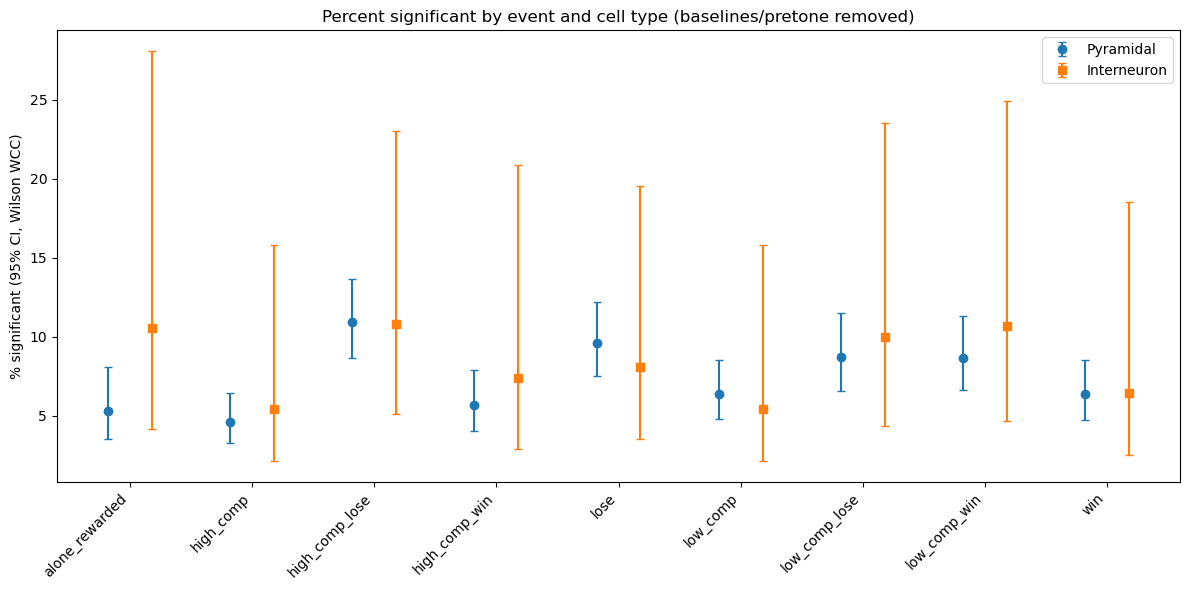

In [94]:
# ---- Clean up CI columns and build safe errorbars ----
# Ensure numeric
for col in ["pct", "ci_lo_pct", "ci_hi_pct"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# If any bounds are swapped, fix them
swap = df["ci_lo_pct"] > df["ci_hi_pct"]
if swap.any():
    df.loc[swap, ["ci_lo_pct", "ci_hi_pct"]] = df.loc[swap, ["ci_hi_pct", "ci_lo_pct"]].to_numpy()

# Non-negative, finite error sizes
df["err_lo"] = np.maximum(0.0, df["pct"] - df["ci_lo_pct"])
df["err_hi"] = np.maximum(0.0, df["ci_hi_pct"] - df["pct"])

# We'll plot only fully valid rows (x, y, and both errors finite)
valid = np.isfinite(df["pct"]) & np.isfinite(df["err_lo"]) & np.isfinite(df["err_hi"])

# Split masks (keep event/cell_type ordering you already set)
pyr_mask = df["cell_type"].eq("pyramidal") & valid
itn_mask = df["cell_type"].eq("interneuron") & valid

# Recompute x positions aligned to the filtered rows
# map event -> index (x_base) and add offsets per cell type
event_to_ix = {e: i for i, e in enumerate(events_unique)}
x_all = df["event"].map(event_to_ix).to_numpy()
x_positions = x_all.astype(float)
x_positions[df["cell_type"].eq("pyramidal")]  -= offset
x_positions[df["cell_type"].eq("interneuron")] += offset

# Now plot safely
plt.figure(figsize=(12, 6))
plt.errorbar(x_positions[pyr_mask], df.loc[pyr_mask, "pct"],
             yerr=np.vstack([df.loc[pyr_mask, "err_lo"], df.loc[pyr_mask, "err_hi"]]),
             fmt='o', capsize=3, label='Pyramidal')

plt.errorbar(x_positions[itn_mask], df.loc[itn_mask, "pct"],
             yerr=np.vstack([df.loc[itn_mask, "err_lo"], df.loc[itn_mask, "err_hi"]]),
             fmt='s', capsize=3, label='Interneuron')

plt.xticks(x_base, events_unique, rotation=45, ha='right')
plt.ylabel('% significant (95% CI, Wilson WCC)')
plt.title('Percent significant by event and cell type (baselines/pretone removed)')
plt.legend()
plt.tight_layout()
plt.show()
